In [1]:
%pwd

u'/home/ubuntu/statefarm'

In [2]:
#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

from __future__ import division,print_function

import os, json, math
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [3]:
#import modules
from utils import *
from vgg16 import Vgg16

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [4]:
#Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir + '/data'
#DATA_HOME_DIR = current_dir + '/data/sample'

In [29]:
DATA_HOME_DIR = LESSON_HOME_DIR + '/data/sample'

In [5]:
test_path = DATA_HOME_DIR + '/test/'
results_path=DATA_HOME_DIR + '/results/'
train_path= DATA_HOME_DIR + '/train/'
valid_path = DATA_HOME_DIR + '/valid/'

In [6]:
def get_driver_data():
    dr = dict()
    path = os.path.join(DATA_HOME_DIR, 'driver_imgs_list.csv')
    print('Read drivers data')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
    f.close()
    return dr

In [7]:
import cv2

# color_type = 1 - gray
# color_type = 3 - RGB
def get_im_cv2(path, img_rows, img_cols, color_type=1):
    # Load as grayscale
    if color_type == 1:
        img = cv2.imread(path, 0)
    elif color_type == 3:
        img = cv2.imread(path)
    # Reduce size
    resized = cv2.resize(img, (img_cols, img_rows))
    return resized

In [8]:
#driver_data = get_driver_data()

In [9]:
#print(len(driver_data))

In [10]:
# read in the 'driver_imgs_list.csv' file
driver_file = DATA_HOME_DIR +'/driver_imgs_list.csv'
driver_df = pd.read_csv(driver_file)
print(driver_df[:2])

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg


In [11]:
print(len(driver_df))

22424


In [12]:
# Unique driver IDs
unique_drivers = sorted(list(set(driver_df['subject'])))
print(len(unique_drivers))
print(unique_drivers)

26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']


In [13]:
ud = driver_df.groupby('subject').agg({'classname':'min', 'img':'count'})
#print(len(ud))
print(ud)
print(ud['img'].sum())

        classname   img
subject                
p002           c0   725
p012           c0   823
p014           c0   876
p015           c0   875
p016           c0  1078
p021           c0  1237
p022           c0  1233
p024           c0  1226
p026           c0  1196
p035           c0   848
p039           c0   651
p041           c0   605
p042           c0   591
p045           c0   724
p047           c0   835
p049           c0  1011
p050           c0   790
p051           c0   920
p052           c0   740
p056           c0   794
p061           c0   809
p064           c0   820
p066           c0  1034
p072           c0   346
p075           c0   814
p081           c0   823
22424


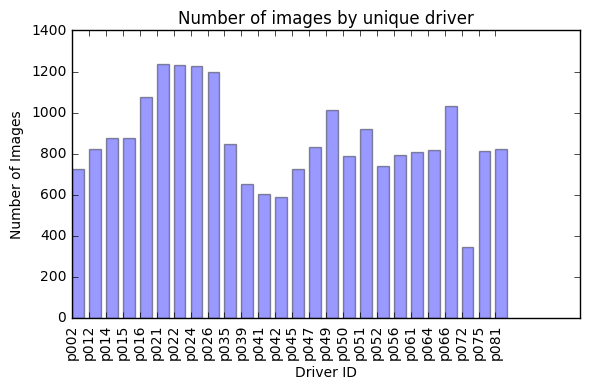

In [14]:
n_groups = len(unique_drivers)
ud = ud.reset_index()

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.7

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, ud['img'], bar_width,
                 alpha=opacity,
                 color='b')

plt.xlabel('Driver ID')
plt.ylabel('Number of Images')
plt.title('Number of images by unique driver')
plt.xticks(index, ud['subject'], rotation=90)
plt.tight_layout()
plt.show()

In [21]:
def reset_and_create_valid_data():
#    %cd $DATA_HOME_DIR/valid
#    g = glob('c*/*.jpg')
#    for ga in g:
#        os.rename(DATA_HOME_DIR+'/valid/'+ga, DATA_HOME_DIR+'/train/'+ga)

    # Select 5 random drivers for validation
    import random
    selected_drivers = random.sample(unique_drivers, 5)
    print(selected_drivers)
    
    selected_files = driver_df[driver_df['subject'].isin(selected_drivers)]
    print(len(selected_files))
    
    for index, row in selected_files.iterrows():
        source_file = DATA_HOME_DIR + '/train/' + row['classname'] + '/' + row['img']
        target_file = DATA_HOME_DIR + '/valid/' + row['classname'] + '/' + row['img']
        #print("Source", source_file)
        #print("Target", target_file)
        os.rename(source_file, target_file)

In [22]:
reset_and_create_valid_data()

['p081', 'p012', 'p015', 'p051', 'p049']
4452
Source /home/ubuntu/statefarm/data/train/c0/img_10206.jpg
Target /home/ubuntu/statefarm/data/valid/c0/img_10206.jpg
Source /home/ubuntu/statefarm/data/train/c0/img_27079.jpg
Target /home/ubuntu/statefarm/data/valid/c0/img_27079.jpg
Source /home/ubuntu/statefarm/data/train/c0/img_50749.jpg
Target /home/ubuntu/statefarm/data/valid/c0/img_50749.jpg
Source /home/ubuntu/statefarm/data/train/c0/img_97089.jpg
Target /home/ubuntu/statefarm/data/valid/c0/img_97089.jpg
Source /home/ubuntu/statefarm/data/train/c0/img_37741.jpg
Target /home/ubuntu/statefarm/data/valid/c0/img_37741.jpg
Source /home/ubuntu/statefarm/data/train/c0/img_65697.jpg
Target /home/ubuntu/statefarm/data/valid/c0/img_65697.jpg
Source /home/ubuntu/statefarm/data/train/c0/img_3866.jpg
Target /home/ubuntu/statefarm/data/valid/c0/img_3866.jpg
Source /home/ubuntu/statefarm/data/train/c0/img_19098.jpg
Target /home/ubuntu/statefarm/data/valid/c0/img_19098.jpg
Source /home/ubuntu/statefar

In [24]:
from shutil import copyfile
%cd data/train
%pwd

/home/ubuntu/statefarm/data/train


u'/home/ubuntu/statefarm/data/train'

In [25]:
g = glob('c?/*.jpg')
shuf = np.random.permutation(g)
for i in range(1500): copyfile(shuf[i], '../sample/train/' + shuf[i])

In [26]:
%cd ../valid

/home/ubuntu/statefarm/data/valid


In [27]:
g = glob('c?/*.jpg')
shuf = np.random.permutation(g)
for i in range(1000): copyfile(shuf[i], '../sample/valid/' + shuf[i])

# Create Batches

In [30]:
batch_size = 64
DATA_HOME_DIR = LESSON_HOME_DIR + '/data'
print (DATA_HOME_DIR)

/home/ubuntu/statefarm/data/sample


In [31]:
batches = get_batches(DATA_HOME_DIR+'/train', batch_size=batch_size)
val_batches = get_batches(DATA_HOME_DIR+'/valid', batch_size=batch_size*2, shuffle=False)

Found 1500 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [33]:
(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames,
    test_filename) = get_classes(DATA_HOME_DIR+'/')

Found 1500 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 0 images belonging to 0 classes.


# Linear Model

In [34]:
model = Sequential([
        BatchNormalization(axis=1, input_shape=(3,224,224)),
        Flatten(),
        Dense(10, activation='softmax')
    ])

In [35]:
model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(batches, batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

Epoch 1/2
1500/1500 [==============================] - 31s - loss: 13.2634 - acc: 0.1287 - val_loss: 14.2162 - val_acc: 0.1180
Epoch 2/2
1500/1500 [==============================] - 24s - loss: 13.5523 - acc: 0.1520 - val_loss: 13.9856 - val_acc: 0.1290


In [36]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNormal(None, 3, 224, 224)   6           batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 150528)        0           batchnormalization_1[0][0]       
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 10)            1505290     flatten_1[0][0]                  
Total params: 1505296
____________________________________________________________________________________________________


In [37]:
np.round(model.predict_generator(batches, batches.N)[:10],2)

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]], dtype=float32)

In [38]:
model = Sequential([
        BatchNormalization(axis=1, input_shape=(3,224,224)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(batches, batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

Epoch 1/2
1500/1500 [==============================] - 31s - loss: 2.3238 - acc: 0.2187 - val_loss: 4.0377 - val_acc: 0.1050
Epoch 2/2
1500/1500 [==============================] - 24s - loss: 1.6976 - acc: 0.4427 - val_loss: 2.8621 - val_acc: 0.2020


In [41]:
np.round(model.predict_generator(batches, batches.N)[:20],2)

array([[ 0.  ,  0.  ,  0.01,  0.  ,  0.  ,  0.  ,  0.01,  0.  ,  0.03,  0.96],
       [ 0.3 ,  0.01,  0.18,  0.12,  0.16,  0.02,  0.  ,  0.02,  0.  ,  0.19],
       [ 0.02,  0.  ,  0.66,  0.03,  0.09,  0.09,  0.  ,  0.  ,  0.  ,  0.11],
       [ 0.07,  0.03,  0.14,  0.05,  0.05,  0.02,  0.01,  0.06,  0.01,  0.56],
       [ 0.01,  0.04,  0.03,  0.01,  0.01,  0.02,  0.  ,  0.02,  0.01,  0.87],
       [ 0.12,  0.04,  0.03,  0.22,  0.16,  0.19,  0.02,  0.05,  0.  ,  0.17],
       [ 0.06,  0.02,  0.11,  0.12,  0.08,  0.03,  0.03,  0.05,  0.01,  0.49],
       [ 0.01,  0.  ,  0.01,  0.06,  0.08,  0.01,  0.  ,  0.  ,  0.  ,  0.83],
       [ 0.04,  0.  ,  0.02,  0.11,  0.06,  0.73,  0.  ,  0.  ,  0.  ,  0.03],
       [ 0.  ,  0.  ,  0.03,  0.  ,  0.  ,  0.  ,  0.03,  0.02,  0.01,  0.9 ],
       [ 0.21,  0.  ,  0.15,  0.07,  0.41,  0.02,  0.  ,  0.05,  0.02,  0.06],
       [ 0.  ,  0.  ,  0.07,  0.  ,  0.  ,  0.08,  0.01,  0.05,  0.01,  0.78],
       [ 0.03,  0.  ,  0.  ,  0.  ,  0.01,  0.01,  0

In [42]:
model.optimizer.lr=0.001

In [43]:
model.fit_generator(batches, batches.nb_sample, nb_epoch=4, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

Epoch 1/4
1500/1500 [==============================] - 32s - loss: 1.3353 - acc: 0.6300 - val_loss: 2.5028 - val_acc: 0.2560
Epoch 2/4
1500/1500 [==============================] - 24s - loss: 1.0940 - acc: 0.7113 - val_loss: 2.4687 - val_acc: 0.2220
Epoch 3/4
1500/1500 [==============================] - 24s - loss: 0.9282 - acc: 0.8000 - val_loss: 2.0478 - val_acc: 0.3420
Epoch 4/4
1500/1500 [==============================] - 24s - loss: 0.7790 - acc: 0.8433 - val_loss: 2.0059 - val_acc: 0.3500


In [44]:
rnd_batches = get_batches(DATA_HOME_DIR+'/valid', batch_size=batch_size*2, shuffle=True)

Found 1000 images belonging to 10 classes.


In [45]:
val_res = [model.evaluate_generator(rnd_batches, rnd_batches.nb_sample) for i in range(10)]
np.round(val_res, 2)

array([[ 2.01,  0.35],
       [ 2.  ,  0.34],
       [ 2.04,  0.34],
       [ 1.98,  0.37],
       [ 2.04,  0.34],
       [ 1.96,  0.36],
       [ 2.03,  0.35],
       [ 1.96,  0.36],
       [ 2.01,  0.35],
       [ 2.  ,  0.35]])

# L2 regularization

In [46]:
model = Sequential([
        BatchNormalization(axis=1, input_shape=(3,224,224)),
        Flatten(),
        Dense(10, activation='softmax', W_regularizer=l2(0.01))
    ])
model.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(batches, batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

Epoch 1/2
1500/1500 [==============================] - 31s - loss: 5.8072 - acc: 0.2387 - val_loss: 13.3535 - val_acc: 0.0940
Epoch 2/2
1500/1500 [==============================] - 25s - loss: 1.9720 - acc: 0.6087 - val_loss: 4.9711 - val_acc: 0.2850


In [47]:
model.optimizer.lr=0.001

In [48]:
model.fit_generator(batches, batches.nb_sample, nb_epoch=4, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

Epoch 1/4
1500/1500 [==============================] - 32s - loss: 0.6945 - acc: 0.8567 - val_loss: 3.2705 - val_acc: 0.3940
Epoch 2/4
1500/1500 [==============================] - 24s - loss: 0.4980 - acc: 0.9193 - val_loss: 3.3698 - val_acc: 0.3680
Epoch 3/4
1500/1500 [==============================] - 24s - loss: 0.3868 - acc: 0.9587 - val_loss: 2.7851 - val_acc: 0.3920
Epoch 4/4
1500/1500 [==============================] - 24s - loss: 0.3022 - acc: 0.9813 - val_loss: 2.8289 - val_acc: 0.3950


# Hidden Layer

In [49]:
model = Sequential([
        BatchNormalization(axis=1, input_shape=(3,224,224)),
        Flatten(),
        Dense(100, activation='relu'),
        BatchNormalization(),
        Dense(10, activation='softmax')
    ])
model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(batches, batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

model.optimizer.lr = 0.01
model.fit_generator(batches, batches.nb_sample, nb_epoch=5, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

Epoch 1/2
1500/1500 [==============================] - 32s - loss: 2.0107 - acc: 0.3540 - val_loss: 9.0121 - val_acc: 0.1380
Epoch 2/2
1500/1500 [==============================] - 24s - loss: 1.0201 - acc: 0.7353 - val_loss: 5.4555 - val_acc: 0.1620
Epoch 1/5
1500/1500 [==============================] - 32s - loss: 0.5948 - acc: 0.8833 - val_loss: 2.9374 - val_acc: 0.2080
Epoch 2/5
1500/1500 [==============================] - 24s - loss: 0.3947 - acc: 0.9440 - val_loss: 1.9581 - val_acc: 0.4030
Epoch 3/5
1500/1500 [==============================] - 25s - loss: 0.2503 - acc: 0.9753 - val_loss: 1.8463 - val_acc: 0.4030
Epoch 4/5
1500/1500 [==============================] - 24s - loss: 0.1878 - acc: 0.9887 - val_loss: 1.9030 - val_acc: 0.3830
Epoch 5/5
1500/1500 [==============================] - 25s - loss: 0.1501 - acc: 0.9927 - val_loss: 1.7568 - val_acc: 0.4410


# Convolutional Layer

In [50]:
def conv1(batches):
    model = Sequential([
            BatchNormalization(axis=1, input_shape=(3,224,224)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Flatten(),
            Dense(200, activation='relu'),
            BatchNormalization(),
            Dense(10, activation='softmax')
        ])

    model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit_generator(batches, batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
    model.optimizer.lr = 0.001
    model.fit_generator(batches, batches.nb_sample, nb_epoch=4, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
    return model

In [51]:
conv1(batches)

Epoch 1/2
1500/1500 [==============================] - 34s - loss: 1.5858 - acc: 0.5353 - val_loss: 2.7263 - val_acc: 0.1610
Epoch 2/2
1500/1500 [==============================] - 29s - loss: 0.3581 - acc: 0.9293 - val_loss: 2.3829 - val_acc: 0.1560
Epoch 1/4
1500/1500 [==============================] - 34s - loss: 0.0980 - acc: 0.9933 - val_loss: 2.1240 - val_acc: 0.2030
Epoch 2/4
1500/1500 [==============================] - 28s - loss: 0.0521 - acc: 0.9960 - val_loss: 2.1223 - val_acc: 0.2210
Epoch 3/4
1500/1500 [==============================] - 28s - loss: 0.0276 - acc: 1.0000 - val_loss: 2.1184 - val_acc: 0.2370
Epoch 4/4
1500/1500 [==============================] - 26s - loss: 0.0168 - acc: 1.0000 - val_loss: 2.0899 - val_acc: 0.2690


# Data Augmentation

In [52]:
gen_t = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)
batches = get_batches(DATA_HOME_DIR+'/train', gen_t, batch_size=batch_size)

Found 1500 images belonging to 10 classes.


In [53]:
model = conv1(batches)

Epoch 1/2
1500/1500 [==============================] - 37s - loss: 2.4916 - acc: 0.2367 - val_loss: 2.4520 - val_acc: 0.1370
Epoch 2/2
1500/1500 [==============================] - 27s - loss: 1.6834 - acc: 0.4233 - val_loss: 2.4213 - val_acc: 0.0930
Epoch 1/4
1500/1500 [==============================] - 34s - loss: 1.3898 - acc: 0.5240 - val_loss: 2.3835 - val_acc: 0.1150
Epoch 2/4
1500/1500 [==============================] - 29s - loss: 1.1891 - acc: 0.6020 - val_loss: 2.3659 - val_acc: 0.1380
Epoch 3/4
1500/1500 [==============================] - 29s - loss: 1.1407 - acc: 0.6227 - val_loss: 2.2875 - val_acc: 0.1760
Epoch 4/4
1500/1500 [==============================] - 28s - loss: 0.9918 - acc: 0.6820 - val_loss: 2.2336 - val_acc: 0.2230


In [54]:
model.optimizer.lr = 0.0001
model.fit_generator(batches, batches.nb_sample, nb_epoch=5, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

Epoch 1/5
1500/1500 [==============================] - 34s - loss: 0.9632 - acc: 0.6853 - val_loss: 2.1253 - val_acc: 0.2490
Epoch 2/5
1500/1500 [==============================] - 28s - loss: 0.8828 - acc: 0.7233 - val_loss: 1.9772 - val_acc: 0.3210
Epoch 3/5
1500/1500 [==============================] - 26s - loss: 0.8213 - acc: 0.7427 - val_loss: 1.9380 - val_acc: 0.3790
Epoch 4/5
1500/1500 [==============================] - 26s - loss: 0.7595 - acc: 0.7613 - val_loss: 1.8279 - val_acc: 0.3610
Epoch 5/5
1500/1500 [==============================] - 29s - loss: 0.7417 - acc: 0.7633 - val_loss: 1.7700 - val_acc: 0.4070


In [55]:
model.fit_generator(batches, batches.nb_sample, nb_epoch=25, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

Epoch 1/25
1500/1500 [==============================] - 34s - loss: 0.6780 - acc: 0.7933 - val_loss: 1.7772 - val_acc: 0.4460
Epoch 2/25
1500/1500 [==============================] - 27s - loss: 0.6297 - acc: 0.8127 - val_loss: 1.7158 - val_acc: 0.4560
Epoch 3/25
1500/1500 [==============================] - 30s - loss: 0.6223 - acc: 0.7960 - val_loss: 1.6007 - val_acc: 0.5110
Epoch 4/25
1500/1500 [==============================] - 27s - loss: 0.5830 - acc: 0.8187 - val_loss: 1.6284 - val_acc: 0.4910
Epoch 5/25
1500/1500 [==============================] - 27s - loss: 0.5675 - acc: 0.8293 - val_loss: 1.6030 - val_acc: 0.5380
Epoch 6/25
1500/1500 [==============================] - 32s - loss: 0.5473 - acc: 0.8373 - val_loss: 1.5648 - val_acc: 0.4940
Epoch 7/25
1500/1500 [==============================] - 28s - loss: 0.5240 - acc: 0.8440 - val_loss: 1.5827 - val_acc: 0.5190
Epoch 8/25
1500/1500 [==============================] - 28s - loss: 0.5062 - acc: 0.8393 - val_loss: 1.6116 - val_acc:

In [15]:
# Plot drivers and training images
"""
img_rows = 244
img_cols = 244
color_type = 1
X_train = []
y_train = [] 
driver_id = []


for j in range(10):
    print('Load folder c{}'.format(j))
    path = os.path.join(DATA_HOME_DIR, 'train', 'c' + str(j), '*.jpg')
    files = glob(path)
    for fl in files:
        flbase = os.path.basename(fl)
        img = get_im_cv2(fl, img_rows, img_cols, color_type)
        X_train.append(img)
        y_train.append(j)
        driver_id.append(driver_data[flbase])

unique_drivers = sorted(list(set(driver_id)))
print('Unique drivers: {}'.format(len(unique_drivers)))
print(unique_drivers)
"""

"\nimg_rows = 244\nimg_cols = 244\ncolor_type = 1\nX_train = []\ny_train = [] \ndriver_id = []\n\n\nfor j in range(10):\n    print('Load folder c{}'.format(j))\n    path = os.path.join(DATA_HOME_DIR, 'train', 'c' + str(j), '*.jpg')\n    files = glob(path)\n    for fl in files:\n        flbase = os.path.basename(fl)\n        img = get_im_cv2(fl, img_rows, img_cols, color_type)\n        X_train.append(img)\n        y_train.append(j)\n        driver_id.append(driver_data[flbase])\n\nunique_drivers = sorted(list(set(driver_id)))\nprint('Unique drivers: {}'.format(len(unique_drivers)))\nprint(unique_drivers)\n"

In [16]:
"""
# images per driver
drivernumbers = dict()
drivers = list(driver_id)
for i in range(len(unique_drivers)):
    x = drivers.count(unique_drivers[i])
    drivernumbers[unique_drivers[i]] = x
print(drivernumbers)
"""

'\n# images per driver\ndrivernumbers = dict()\ndrivers = list(driver_id)\nfor i in range(len(unique_drivers)):\n    x = drivers.count(unique_drivers[i])\n    drivernumbers[unique_drivers[i]] = x\nprint(drivernumbers)\n'

In [17]:
"""
x = 0
a = list(drivernumbers.values())
for y in range(len(a)):
    x += a[y]
print(x)
"""

'\nx = 0\na = list(drivernumbers.values())\nfor y in range(len(a)):\n    x += a[y]\nprint(x)\n'

In [18]:
"""
n_groups = len(drivernumbers)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.7

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, drivernumbers.values(), bar_width,
                 alpha=opacity,
                 color='b')

plt.xlabel('Driver ID')
plt.ylabel('Number of Images')
plt.title('Number of images by unique driver')
plt.xticks(index, drivernumbers.keys(), rotation=90)
plt.tight_layout()
plt.show()
"""

"\nn_groups = len(drivernumbers)\n\nfig, ax = plt.subplots()\n\nindex = np.arange(n_groups)\nbar_width = 0.7\n\nopacity = 0.4\nerror_config = {'ecolor': '0.3'}\n\nrects1 = plt.bar(index, drivernumbers.values(), bar_width,\n                 alpha=opacity,\n                 color='b')\n\nplt.xlabel('Driver ID')\nplt.ylabel('Number of Images')\nplt.title('Number of images by unique driver')\nplt.xticks(index, drivernumbers.keys(), rotation=90)\nplt.tight_layout()\nplt.show()\n"

In [19]:
"""
# Move files for random drivers from train directory to valid directory for each category
import random
from random import sample

selected_drivers = random.sample(unique_drivers, 5)
print(selected_drivers)
selected_files = []

ddv = list(driver_data.values())
ddk = list(driver_data.keys())

for i in range(len(ddv)):
    if (ddv[i] == selected_drivers[0]):
        selected_files.append(ddk[i])
        
print (len(selected_files))
print(selected_files[0])

filea = []

for d in range(10):
    for c in range(10):
        sourcepath = os.path.join(DATA_HOME_DIR, 'train', 'c' + str(c), selected_files[d])
        a = glob(sourcepath)
        print("Sourcepath", sourcepath)
        if (len(a) != 0):
            filea.append(glob(sourcepath))
            break
    
print("filea len", len(filea))
print(filea[:10])

#for i in range(len(selected_drivers)):
#    selected_files[i].append(list(driver_data.keys())[list(driver_data.values()).index(selected_drivers[i])])

#print(len(selected_files[0]))    

#SOURCE_DIR = DATA_HOME_DIR + '/train/c' + str(category_idx)
#TARGET_DIR = DATA_HOME_DIR + '/valid/c' + str(category_idx)
    


#    %mkdir -p $TARGET_DIR
#    %cd $SOURCE_DIR
#    g = glob('*.jpg')
#    print(g)
"""

'\n# Move files for random drivers from train directory to valid directory for each category\nimport random\nfrom random import sample\n\nselected_drivers = random.sample(unique_drivers, 5)\nprint(selected_drivers)\nselected_files = []\n\nddv = list(driver_data.values())\nddk = list(driver_data.keys())\n\nfor i in range(len(ddv)):\n    if (ddv[i] == selected_drivers[0]):\n        selected_files.append(ddk[i])\n        \nprint (len(selected_files))\nprint(selected_files[0])\n\nfilea = []\n\nfor d in range(10):\n    for c in range(10):\n        sourcepath = os.path.join(DATA_HOME_DIR, \'train\', \'c\' + str(c), selected_files[d])\n        a = glob(sourcepath)\n        print("Sourcepath", sourcepath)\n        if (len(a) != 0):\n            filea.append(glob(sourcepath))\n            break\n    \nprint("filea len", len(filea))\nprint(filea[:10])\n\n#for i in range(len(selected_drivers)):\n#    selected_files[i].append(list(driver_data.keys())[list(driver_data.values()).index(selected_drive

In [20]:
"""
g = glob('*.jpg')
    randomfiles = np.random.permutation(g)
    for i in range(400): 
        os.rename(randomfiles[i], DATA_HOME_DIR+'/valid/c' + str(category_idx) + '/' + randomfiles[i])
"""

"\ng = glob('*.jpg')\n    randomfiles = np.random.permutation(g)\n    for i in range(400): \n        os.rename(randomfiles[i], DATA_HOME_DIR+'/valid/c' + str(category_idx) + '/' + randomfiles[i])\n"